# **Predicting Medical Insurance Costs in the US**

Training a linear regression model (gradient descent algorithm) to predict medical insurance costs in the US.

In [1]:
import numpy as np 
import pandas as pd 

In [3]:
#read in csv file
insurance = pd.read_csv('insurance.csv')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### **EXPLORING THE DATASET**

In [5]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are 1338 entries, and 7 variables in this dataset. There are no missing values. The variables in this dataset are:

* age: age of primary beneficiary
* sex: sex of primary beneficiary - female or male
* bmi: body mass index (healthy bmi is considered to be between 18.5 and 24.9)
* children: number of children covered by health insurance / number of dependents
* smoker: is the beneficiary a smoker - yes or no
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: individual medical costs billed by health insurance

We will be trying to predict the medical costs based on one or more of the features listed. Our target variable is 'charges'. This is a continuous variable, and so the prediction model will be a **linear regression** model.

Three of the seven variables are categorical variables -'sex', 'smoker', and 'region'. 'sex' and 'smoker' are binary in nature (male/female, yes/no). We will create dummy variables for each of the three categorical variables.

In [7]:
categorical_vars = ['sex', 'smoker', 'region']

for var in categorical_vars:
    dummies = pd.get_dummies(insurance[var], prefix = var)
    insurance = pd.concat([insurance, dummies], axis=1)
    
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 15 columns):
age                 1338 non-null int64
sex                 1338 non-null object
bmi                 1338 non-null float64
children            1338 non-null int64
smoker              1338 non-null object
region              1338 non-null object
charges             1338 non-null float64
sex_female          1338 non-null uint8
sex_male            1338 non-null uint8
smoker_no           1338 non-null uint8
smoker_yes          1338 non-null uint8
region_northeast    1338 non-null uint8
region_northwest    1338 non-null uint8
region_southeast    1338 non-null uint8
region_southwest    1338 non-null uint8
dtypes: float64(2), int64(2), object(3), uint8(8)
memory usage: 83.8+ KB


Instead of dropping the features we do not need, we will create a list of the features to be used in the regression model which we will use to index into the *insurance* dataset. We will drop features from the list when they are not required for the model.

In [8]:
#list of features for model
features = insurance.columns.tolist()
#removing categoricals 'sex', 'smoker', 'region' as we have created dummy variables for them; also remove target variable 'charges'
for f in ['sex','smoker','region','charges']:
    features.remove(f)
#check
features

['age',
 'bmi',
 'children',
 'sex_female',
 'sex_male',
 'smoker_no',
 'smoker_yes',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

Let's have a look at the basic distribution of the features which are continuous in nature and also of the target variable.

In [9]:
insurance[['age', 'bmi', 'children', 'charges']].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The average age of the dataset is 39, and the ages range from 18 - 64 (no elderly people in the dataset - the retirement age in the US is 62). 

The average bmi is 30 which is considered to be the lower bound of the bmi obese range. The smallest bmi in the dataset is 15.96 which is severely underweight. Interestingly, three quarters of the dataset population are overweight, according to thee bmi metric.

The average number of children is 1.

There is huge variation in the medical charges. The maximum charge is at least 3.8 times larger than the charges of three quarters of the dataset. 

We will note here that before we fit the regression model, we will need to scale the 'age', bmi', 'children', and 'charges' variables.

Strong correlation between features will lead to an inefficient model. We know that the dummy variables 'sex_male' and 'sex_female' are strongly related as one implies the other so we will drop 'sex_male' from our list of features for the model. Likewise, we will drop 'smoker_no'.

In [10]:
for f in ['sex_male','smoker_no']:
    features.remove(f)

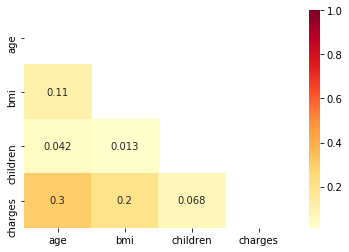

In [25]:
#pairwise correlation between features 'age','bmi','children', and the target variable 'charges'
corr = insurance[['age','bmi','children','charges']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="YlOrRd", annot=True)
bottom, top = plt.ylim() 
bottom += 0.5 
top -= 0.5 
plt.ylim(bottom, top)
plt.show()

'age', 'bmi', and 'children' are  weakly correlated with each other and the target variable. 'children' is the feature with the weakest correlation with the target variable.

Let's plot each of the above features and 'charges' to see if there are any non-linear relationships.

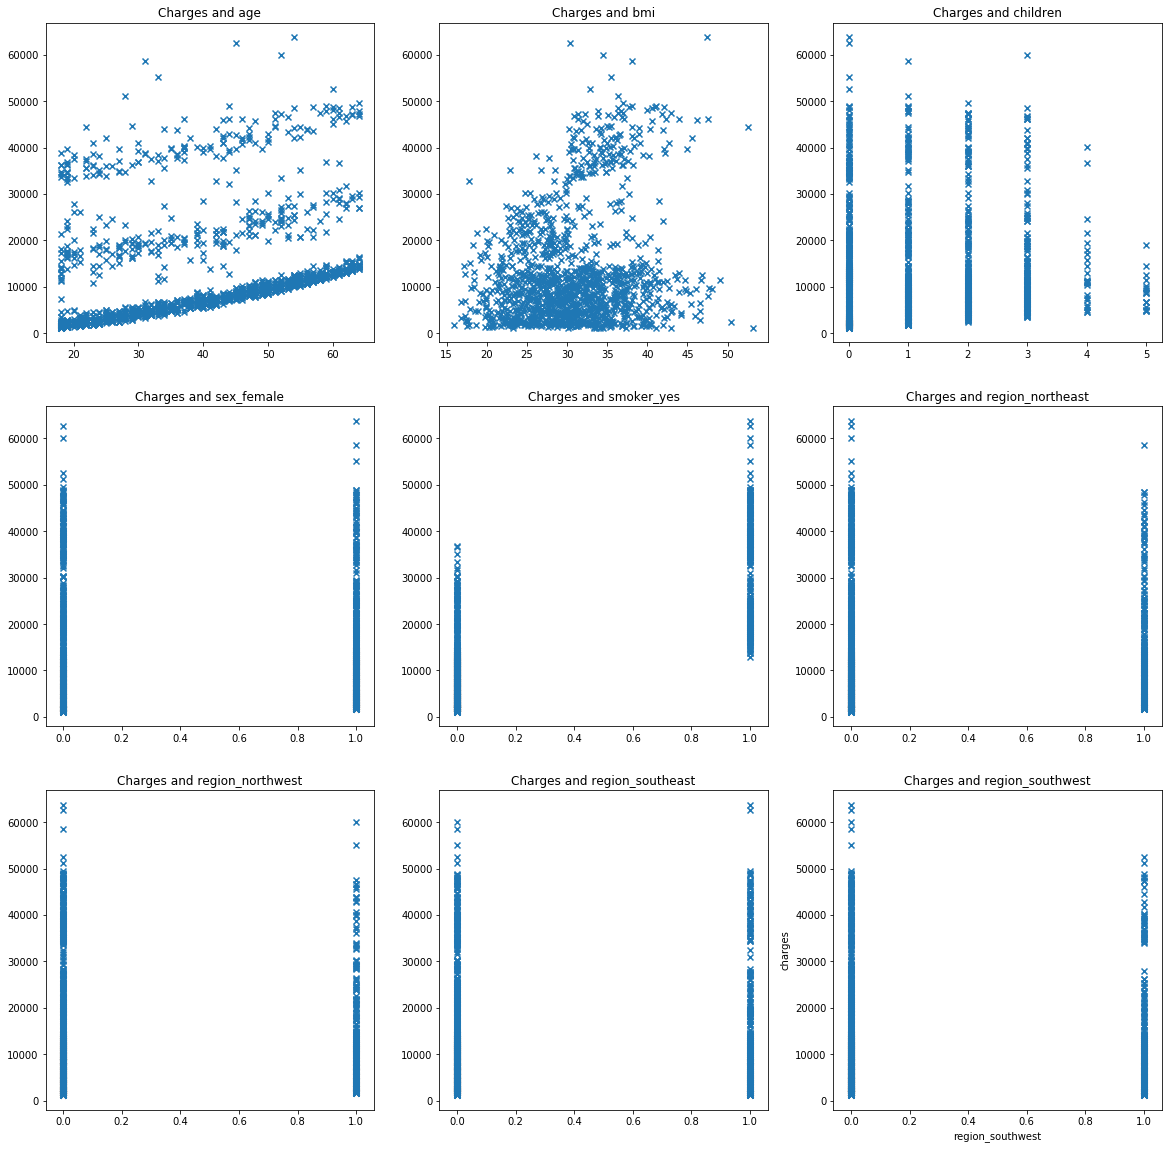

In [12]:
#scatter plots
fig, axs = plt.subplots(3,3, figsize= (20,20))

f = 0
for i in range(3):
    for j in range(3):
        axs[i,j].scatter(insurance[features[f]], insurance['charges'], marker = 'x')
        axs[i,j].set_title('Charges and '+ features[f])
        plt.xlabel(features[f])
        plt.ylabel('charges')
        f += 1
    
plt.show()

Things to note from the scatter plots:

* There is an upward trend in charges with age. 
* Charges trend upwards somewhat with bmi, but most points are clumped together on the bottom with no discernible trend.
* The maximum amount of charges drop with the fourth and fifth child.
* Smokers pay higher charges, on average, than non-smokers.
* There are no striking relationships between charges and sex or between charges and any of the regions.

## Linear Regression

We will first split the model into training and testing sets, and then scale each set using mean normalisation.

In [13]:
#splitting the insurance data set into train and test datasets
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(insurance[features], insurance['charges'], test_size = 0.2, random_state=0)

In [14]:
#scale features and target
for f in ['age', 'bmi', 'children']:
    train_X[f + '_scaled'] = (train_X[f]- train_X[f].mean())/(train_X[f].std())
    test_X[f + '_scaled'] = (test_X[f]- test_X[f].mean())/(test_X[f].std())
    features.append(f + '_scaled')
    features.remove(f)
    
    
train_y = (train_y - train_y.mean())/(train_y.std())
test_y = (test_y - test_y.mean())/(test_y.std())

In [15]:
print(features)
print(train_X.columns)
print(test_X.columns)

['sex_female', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'age_scaled', 'bmi_scaled', 'children_scaled']
Index(['age', 'bmi', 'children', 'sex_female', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_scaled', 'bmi_scaled', 'children_scaled'],
      dtype='object')
Index(['age', 'bmi', 'children', 'sex_female', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_scaled', 'bmi_scaled', 'children_scaled'],
      dtype='object')


IMPLEMENTING GRADIENT DESCENT

<p><font size = 3><ins>**Hypothesis function:**</ins></font></p>
<p>$ h_\theta(x) = \theta_0 + \theta_1*sex\_female + \theta_2*smoker\_yes + \theta_3*region\_northeast + \theta_4*region\_northwest + \theta_3*region\_southeast + \theta_6*region\_southwest + \theta_7*age + \theta_8*bmi + \theta_9*children$</p>
 <p>$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + \theta_4x_4 + \theta_3x_5 + \theta_6x_6 + \theta_7x_7 + \theta_8x_8 + \theta_9x_9 = \theta^Tx$</p>

<p><font size = 3><ins>**Cost Function:**</ins></font></p>
<p>$Cost(\theta) = \frac{1}{2m} \sum_{i=1}^m ( h_\theta(x^{(i)}) - y^{(i)} )^2 $ where **m** is the number of entries</p>

<p><font size = 3><ins>**Gradient Descent**</ins></font></p>

<p>Minimise $Cost(\theta)$ with respect to $\theta$</p>

<p>Repeat**{**</p>
<p>$\theta_j := \theta_j - \alpha \frac{\delta}{\delta\theta_j}Cost(\theta)$</p>
<p>simulataneously update $\theta_j$ for **j = 0,...,n** **}** where $\alpha$ is the learning rate and

$\frac{\delta}{\delta\theta_j}Cost(\theta) = \frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$.</p>


In [16]:
#vectorised cost function

def CostFunction(X, y, theta):
    
    m = len(y)
    cost = (1/(2*m))*np.sum((X@theta - y)**2)
    
    return cost

In [17]:

def GradientDescent(X,y,theta,alpha, precision):
  
    m = len(y)
    cost_history = []
    
    previous_cost = CostFunction(X, y, theta)
    cost_history.append(previous_cost)
    cost = 0
    iter = 1
    
    while (previous_cost - cost) > precision:
        if iter == 1:
            pass
        else:
            previous_cost = cost
        theta_temp = np.copy(theta)
        for j in range(len(theta)):
            theta[j] = theta[j] - (alpha/m)*np.sum((X@theta_temp - y)*X[:,j])
        cost = CostFunction(X,y,theta)
        cost_history.append(cost)
        iter +=1
    
    return theta, cost_history

We will convert our data into numpy arrays to work with the algorithm function above, and initalise the vector theta of parameters.

In [18]:
#store target variable in y as numpy array
y = np.array(train_y)
m = len(y)

#X is matrix with features data and a columns of ones as the first column
array_train = np.array(train_X[features])
X = np.insert(array_train, 0, 1, axis=1)

We will use a learning rate of 0.01 and stop the algorithm when there is no difference between the costs of the last two iterations. We will also time how long it took the cost function to converge. We will begin with initial weights of 0.

In [19]:
from time import perf_counter 

time_start = perf_counter()
opt_theta, cost_hist_1 = GradientDescent(X, y, theta = np.zeros(X.shape[1]), alpha = 0.01, precision = 0)
time_stop = perf_counter()
print('Convergence time: {:.2f} seconds'.format(time_stop - time_start))
print('Converged at cost = {:.4f}'.format(cost_hist_1[-1]))

Convergence time: 2.99 seconds
Converged at cost = 0.1314


The gradient function took 3 seconds to converge with a learning rate of 0.01. We will plot the cost history of the algorithm to see if it worked as intended.

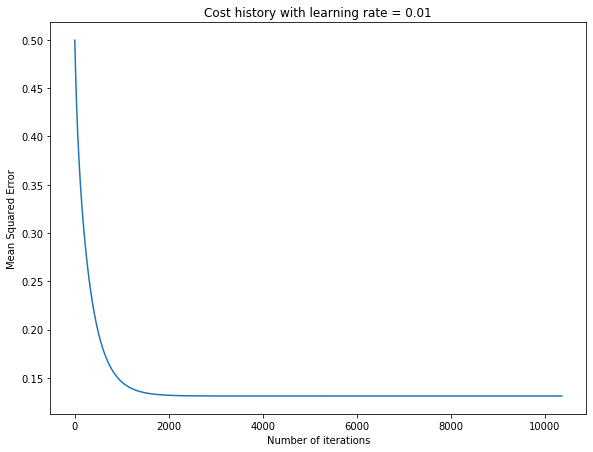

Function converged after 10365 iterations.


In [20]:
plt.figure(figsize = (9.6, 7.2))
plt.plot(cost_hist_1)
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squared Error')
plt.title('Cost history with learning rate = 0.01')
plt.show()

print('Function converged after {} iterations.'.format(len(cost_hist_1)))

The cost has decreased with each iteration. It took over 10000 iterations for the cost function to converge. 

We will now increase the learning rate to 0.1 to see if it converges faster.

In [21]:
#learning rate increased to 0.1
time_start = perf_counter()
opt_theta, cost_hist_2 = GradientDescent(X, y, theta = np.zeros(X.shape[1]), alpha = 0.1, precision = 0)
time_stop = perf_counter()
print('Convergence time: {:.2f} seconds'.format(time_stop - time_start))
print('Converged at cost = {:.4f}'.format(cost_hist_2[-1]))

Convergence time: 0.54 seconds
Converged at cost = 0.1314


Increasing the learning rate to 0.1 decreased the time for the function to converge by roughly 82%. We will plot the cost history to see how the function converged.

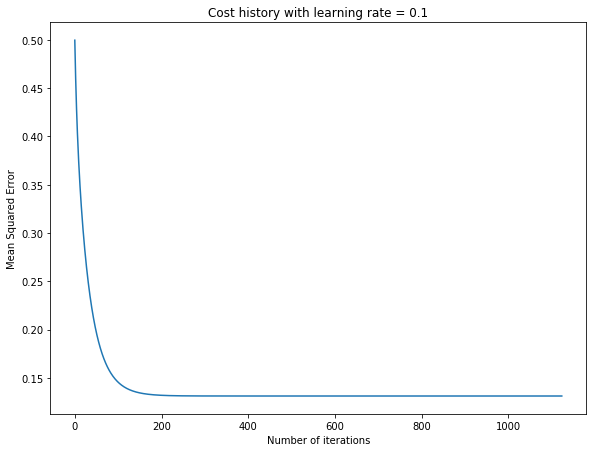

Function converged after 1124 iterations.


In [22]:
plt.figure(figsize = (9.6, 7.2))
plt.plot(cost_hist_2)
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squared Error')
plt.title('Cost history with learning rate = 0.1')
plt.show()

print('Function converged after {} iterations.'.format(len(cost_hist_2)))

In [23]:
print('Increasing the learning rate from 0.01 to 0.1 reduced the number of iterations necessary for the function to converge by {:.2f}%'.format(
    ((len(cost_hist_1) - len(cost_hist_2))/(len(cost_hist_1)))*100))

Increasing the learning rate from 0.01 to 0.1 reduced the number of iterations necessary for the function to converge by 89.16%


The costs at which the function converged with the learning rates of 0.01 and 0.1 are the same. The cost function is convex and has a global minimum, so the algorithm, if working properly, will always find the global minimum of the cost function. The cost is basically the mean squared error of the function for a given weight (theta).


Let's now use the weights which minimised the cost function on the test data, and see how well the model performs.

In [24]:
from sklearn.metrics import mean_squared_error

#convert test_X into numpy array with initial column of ones
array_test = np.array(test_X[features])
X_test = np.insert(array_test, 0, 1, axis=1)
#calculate predictions on test data
predictions_test = X_test@opt_theta
#mean squared error
mse_gd = CostFunction(X_test, test_y, opt_theta)
print('The mean squared error of the model on test data is {:.3f}.'.format(mse_gd))

The mean squared error of the model on test data is 0.099.


The test mean squared error (0.099) is much better than the training mean squared error (13.14). Usually, the test score would be higher than the training score. This suggests that the model will generalise well to unseen data and is not over fitting. Tentatively, this could be a good model for predicting US medical insurance costs. 

This dataset has been useful to practice implementing the gradient descent algorithm for linear regression. 